In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from tensorflow import keras
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.10.0
sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)
matplotlib 3.5.2
numpy 1.23.1
pandas 1.4.4
sklearn 1.1.2
tensorflow 2.10.0
keras.api._v2.keras 2.10.0


* 添加高空层次, 特别是逆温的判别
* 自定义损失函数

In [2]:
if os.environ['COMPUTERNAME'] == 'DESKTOP-EQAO3M5':
  computer_flag = 'home'
else:
  computer_flag = 'office'

if computer_flag == 'home':
  file_dir = "F:/github/pythonScript/seafog/data/collection/"
else:
  file_dir = "H:/github/python/seafog/data/collection/"

In [3]:
def linear_vis(x):
    if(x <= 1000.0):
      y = x/1000.0
    elif(x > 1000.0 and x <= 10000.0):
      y = (x-1000.0)/9000.0 + 1.0
    elif( x > 10000.0  and x <= 30000.0):
      y = (x-10000.0)/20000 + 2.0
    else:
      y = 3.0
    return y

def reverse_linear_vis(x):
    if(x<0):
      y = 1
    elif(x <= 1.0):
      y = x*1000.0
    elif(x <= 2.0):
      y = (x - 1.0)*9000.0 + 1000.0
    elif(x <= 3.0):
      y = (x-2.0)*20000 + 10000.0
    else:
      y = 30000.0
    return y

In [14]:
# fog_dataset_hdf = "H:/github/python/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "F:/github/pythonScript/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "F:/github/pythonScript/seafog/data/collection/extend/fog_dataset_extend.hdf"
# fog_dataset_hdf = os.path.normpath(os.path.join(file_dir, './multi_level/fog_dataset_extend_multilevels.hdf'))
# fog_dataset_hdf = os.path.normpath(os.path.join(file_dir, './fullhour/fog_dataset_72h1_168h6_v2.hdf'))
# fog_dataset_hdf = os.path.normpath(os.path.join(file_dir, './fullhour/fog_dataset_full.suf110.25_20.125_pre110.25_20.25_59754_201508-202205_72h1_168h6_v2.hdf'))
fog_dataset_hdf = os.path.normpath(os.path.join(file_dir, './fog_dataset_allstation.h5'))
store_dataset = pd.HDFStore(fog_dataset_hdf, mode='r')
print(store_dataset.keys())
df_train = store_dataset.get('train')
df_valid =store_dataset.get('valid')
df_test = store_dataset.get('valid_test')

# df_train.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
# df_valid.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)
# df_test.dropna(subset=['visi','v100','v10m','u100','u10m','t2mm','t2md','sstk','station_vis'],inplace=True)


# x_columns = ['t_td', 'td_sst','t_sst','year_sin','year_cos', 'day_sin', 'day_cos','fc_hour',]
df_train['t_td'] =  df_train['t2mm'] - df_train['t2md']
df_train['td_sst'] =  df_train['t2md'] - df_train['sstk']
df_train['t_sst'] =  df_train['t2mm'] - df_train['sstk']
df_train['delta_theta'] = df_train['theta925'] - df_train['theta1000']
df_train['delta_theta_e'] = df_train['theta_e925'] - df_train['theta_e1000']

df_valid['t_td']   =  df_valid['t2mm'] - df_valid['t2md']
df_valid['td_sst'] =  df_valid['t2md'] - df_valid['sstk']
df_valid['t_sst']  =  df_valid['t2mm'] - df_valid['sstk']
df_valid['delta_theta'] = df_valid['theta925'] - df_valid['theta1000']
df_valid['delta_theta_e'] = df_valid['theta_e925'] - df_valid['theta_e1000']

df_test['t_td']   =  df_test['t2mm'] - df_test['t2md']
df_test['td_sst'] =  df_test['t2md'] - df_test['sstk']
df_test['t_sst']  =  df_test['t2mm'] - df_test['sstk']
df_test['delta_theta'] = df_test['theta925'] - df_test['theta1000']
df_test['delta_theta_e'] = df_test['theta_e925'] - df_test['theta_e1000']

x_columns = ['t_td', 'td_sst','t_sst','v100', 'v10m', 'u100', 'u10m', 't2mm', 't2md', 'sstk','year_sin','year_cos', 'day_sin', 'day_cos','fc_hour','delta_theta','delta_theta_e','theta_e925']

df_train_x = df_train.loc[:, x_columns]
df_train_y = df_train['station_vis_linear']

df_valid_x = df_valid.loc[:, x_columns]
df_valid_y = df_valid['station_vis_linear']

df_test_x = df_test.loc[:, x_columns]
df_test_y = df_test['station_vis_linear']

train_x = df_train_x.to_numpy()
train_y = df_train_y.to_numpy()

valid_x = df_valid_x.to_numpy()
valid_y = df_valid_y.to_numpy()

test_x = df_test_x.to_numpy()
test_y = df_test_y.to_numpy()

print(train_x.shape)
print(train_y.shape)

scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled  = scaler.transform(test_x)
valid_x_scaled = scaler.transform(valid_x)


keep_cols = ['t_td', 'td_sst','t_sst','year_sin','year_cos', 'day_sin', 'day_cos','delta_theta','delta_theta_e'] # 不需要标准化变量的参数

for iColumn in keep_cols:
    index = x_columns.index(iColumn)
    train_x_scaled[:,index] = train_x[:,index]
    valid_x_scaled[:,index] = valid_x[:,index]
    test_x_scaled[:,index]  = test_x[:,index]




['/test', '/train', '/valid', '/valid_test']
(282942, 18)
(282942,)


In [5]:
def customized_mes(y_true, y_pred): # 自定义均方差
    '''
    自定义均方差
    '''
    square = tf.square(y_pred - y_true)
    # y_true [0,1] 时的损失函数[0:1, 1:4/3, 4/3:2, 2:3]  ->  [0.2,0.5,1.5,3.0]
    mse_0_1   = tf.where(tf.less_equal(y_pred, tf.constant(1.0)),     square*0.6, 
                tf.where(tf.less_equal(y_pred, tf.constant(4.0/3.0)), square*1.2,
                tf.where(tf.less_equal(y_pred, tf.constant(2.0)),     square*2.0,
                                                                      square*3.0)))
    # y_true [1,4/3] 时的损失函数[0:1, 1:4/3, 4/3:2, 2:3]  ->  [1.0,0.5,1.0,3.0]
    mse_1_43  = tf.where(tf.less_equal(y_pred, tf.constant(1.0)),     square*1.0,
                tf.where(tf.less_equal(y_pred, tf.constant(4.0/3.0)), square*0.6,
                tf.where(tf.less_equal(y_pred, tf.constant(2.0)),     square*1.5,
                                                                      square*3.0)))
    # y_true [4/3,2] 时的损失函数[0:1, 1:4/3, 4/3:2, 2:3]  ->  [2.0,1.square
    mse_43_2  = tf.where(tf.less_equal(y_pred, tf.constant(1.0)),     square*2.2,
                tf.where(tf.less_equal(y_pred, tf.constant(4.0/3.0)), square*1.2,
                tf.where(tf.less_equal(y_pred, tf.constant(2.0)),     square*0.6,
                                                                      square*2.0)))
    # y_true [2,3] 时的损失函数[0:1, 1:4/3, 4/3:2, 2:3]  ->  [3.0,2.0,1.0,0.5]
    mse_2_3   = tf.where(tf.less_equal(y_pred, tf.constant(1.0)),     square*3.0,
                tf.where(tf.less_equal(y_pred, tf.constant(4.0/3.0)), square*2.0,
                tf.where(tf.less_equal(y_pred, tf.constant(2.0)),     square*1.0,
                                                                      square*0.6)))
    sum = tf.where(tf.less_equal(y_true, tf.constant(1.0)),     mse_0_1,
          tf.where(tf.less_equal(y_true, tf.constant(4.0/3.0)), mse_1_43,
          tf.where(tf.less_equal(y_true, tf.constant(2.0)),     mse_43_2, 
                                                                mse_2_3)
          )
        )
    return tf.reduce_mean(sum)

In [6]:
# RandomizedSearchCV
# 1. 转化为sklearn的model
# 2. 定义参数集合
# 3. 搜索参数
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

def build_model(hidden_layers = 1,
                layer_size = 30,
                learning_rate = 3e-3,
                drop_out_layers = 2,
                drop_out_layers_size = 12,
                drop_out_rate = 0.5,):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation='relu', 
                                kernel_regularizer=regularizers.l2(0.0001),
                                input_shape=train_x.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size, activation = 'relu'))

    for _ in range(drop_out_layers - 1):
        model.add(keras.layers.Dense(drop_out_layers_size, activation = 'relu'))
        model.add(keras.layers.Dropout(drop_out_rate))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss = customized_mes, optimizer = optimizer,metrics=["mean_squared_error",])
    return model

sklearn_model = KerasRegressor(build_fn = build_model)
# callbacks = [keras.callbacks.EarlyStopping(patience=8, min_delta=1e-4)]
# history = sklearn_model.fit(train_x_scaled, train_y,
#                             epochs = 50,
#                             validation_data = (valid_x_scaled, valid_y),
#                             callbacks = callbacks)

C:\Users\Henry\AppData\Local\Temp\ipykernel_14148\1293799354.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  sklearn_model = KerasRegressor(build_fn = build_model)


In [7]:
from scipy.stats import reciprocal

# f(x) = 1/(x*log(b/a)) a <= x <= b

param_distribution = {
    "hidden_layers":[1, 2, 3, 4, 5, 6, 7],
    "layer_size": np.arange(1, 100),
    "learning_rate": reciprocal(1e-4, 1e-2),
    "drop_out_layers":[1, 2, 3, 4, 5, 6, 7],
    "drop_out_layers_size":np.arange(1, 100),
    "drop_out_rate":[0.4, 0.45, 0.5, 0.55, 0.6]
}
callbacks = [keras.callbacks.EarlyStopping(patience=8, min_delta=1e-4)]
from sklearn.model_selection import RandomizedSearchCV

random_search_cv = RandomizedSearchCV(sklearn_model,
                                      param_distribution,
                                      n_iter = 10,
                                      cv = 3,
                                      n_jobs = 1)
random_search_cv.fit(train_x_scaled, train_y, epochs = 100,
                     validation_data = (valid_x_scaled, valid_y),
                     callbacks = callbacks)

Epoch 1/100
5895/5895 [==============================] - 39s 6ms/step - loss: 1.4201 - mean_squared_error: 0.8107 - val_loss: 1.3506 - val_mean_squared_error: 0.8529
Epoch 2/100
5895/5895 [==============================] - 35s 6ms/step - loss: 1.0736 - mean_squared_error: 0.7110 - val_loss: 1.3177 - val_mean_squared_error: 0.8398
Epoch 3/100
5895/5895 [==============================] - 36s 6ms/step - loss: 0.9108 - mean_squared_error: 0.6471 - val_loss: 1.3447 - val_mean_squared_error: 0.8195
Epoch 4/100
5895/5895 [==============================] - 36s 6ms/step - loss: 0.7489 - mean_squared_error: 0.5577 - val_loss: 1.3545 - val_mean_squared_error: 0.8033
Epoch 5/100
5895/5895 [==============================] - 40s 7ms/step - loss: 0.6679 - mean_squared_error: 0.5038 - val_loss: 1.3708 - val_mean_squared_error: 0.8036
Epoch 6/100
5895/5895 [==============================] - 40s 7ms/step - loss: 0.6195 - mean_squared_error: 0.4718 - val_loss: 1.3896 - val_mean_squared_error: 0.8034
Epoc

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x00000284D19BADC0>,
                   n_jobs=1,
                   param_distributions={'drop_out_layers': [1, 2, 3, 4, 5, 6,
                                                            7],
                                        'drop_out_layers_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 5...
                                        'layer_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000284DF91F4F0>})

In [8]:
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)
model = random_search_cv.best_estimator_.model
model.evaluate(test_x_scaled, test_y)

{'drop_out_layers': 1, 'drop_out_layers_size': 16, 'drop_out_rate': 0.4, 'hidden_layers': 6, 'layer_size': 87, 'learning_rate': 0.001723947145614866}
-0.17123134434223175
1397/1397 [==============================] - 4s 3ms/step - loss: 0.3661 - mean_squared_error: 0.2527


[0.3660598695278168, 0.25267574191093445]

In [9]:
history = model.fit(train_x_scaled, train_y, epochs=50,
                    validation_data=(valid_x_scaled, valid_y),
                    callbacks = callbacks)

Epoch 1/50
8842/8842 [==============================] - 42s 5ms/step - loss: 0.1731 - mean_squared_error: 0.1505 - val_loss: 0.2811 - val_mean_squared_error: 0.2571
Epoch 2/50
8842/8842 [==============================] - 42s 5ms/step - loss: 0.1701 - mean_squared_error: 0.1484 - val_loss: 0.3349 - val_mean_squared_error: 0.2702
Epoch 3/50
8842/8842 [==============================] - 43s 5ms/step - loss: 0.1679 - mean_squared_error: 0.1465 - val_loss: 0.2680 - val_mean_squared_error: 0.2518
Epoch 4/50
8842/8842 [==============================] - 45s 5ms/step - loss: 0.1650 - mean_squared_error: 0.1447 - val_loss: 0.2908 - val_mean_squared_error: 0.2511
Epoch 5/50
8842/8842 [==============================] - 42s 5ms/step - loss: 0.1631 - mean_squared_error: 0.1433 - val_loss: 0.2704 - val_mean_squared_error: 0.2358
Epoch 6/50
8842/8842 [==============================] - 41s 5ms/step - loss: 0.1609 - mean_squared_error: 0.1415 - val_loss: 0.3456 - val_mean_squared_error: 0.2728
Epoch 7/50

In [16]:

# model_path = os.path.join(file_dir, './fulltime/model_0.818')
# tf.keras.models.save_model(
#     model, model_path, overwrite=True, include_optimizer=True, save_format=None,
#     signatures=None, options=None, save_traces=True
# )
model_path = os.path.join(file_dir, './fulltime/fog_dataset_allstation')
tf.keras.models.save_model(
    model, model_path, overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None, save_traces=True
)

INFO:tensorflow:Assets written to: F:/github/pythonScript/seafog/data/collection/./fulltime/fog_dataset_allstation\assets


In [10]:
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_234 (Dense)           (None, 87)                1653      
                                                                 
 dense_235 (Dense)           (None, 87)                7656      
                                                                 
 dense_236 (Dense)           (None, 87)                7656      
                                                                 
 dense_237 (Dense)           (None, 87)                7656      
                                                                 
 dense_238 (Dense)           (None, 87)                7656      
                                                                 
 dense_239 (Dense)           (None, 87)                7656      
                                                                 
 dense_240 (Dense)           (None, 1)               

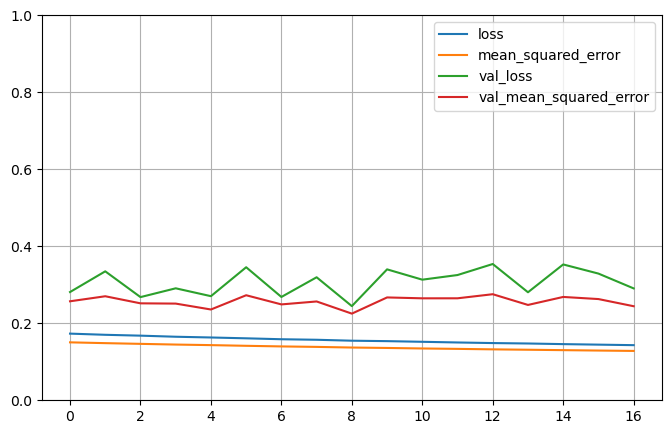

In [11]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [12]:
model.evaluate(test_x_scaled, test_y, verbose=0)

[0.4174034297466278, 0.2820796072483063]

* 默认方法MSE 在0.36左右，关键因素是温度和日期
* 添加t-td 等函数后，MSE 在0.3
* hp 搜索后MSE达到了0.245

[0.3626589775085449, 0.261361688375473]


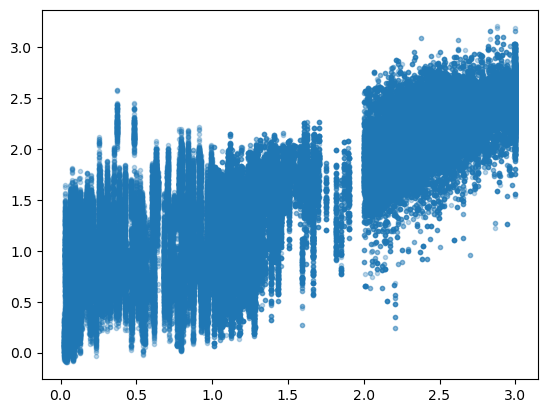

相关系数0.810682433396698, p值为0.00000


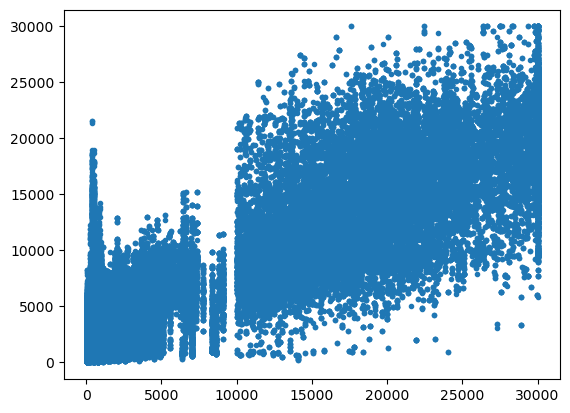

In [15]:
print(model.evaluate(test_x_scaled, test_y, verbose=0))
predictions = model(test_x_scaled).numpy()
plt.plot(test_y, predictions,'.', alpha=0.3)
plt.show()
r,p = pearsonr(predictions[:,0],test_y)
print(f'相关系数{r}, p值为{p:.5f}')

plt.plot(df_test['station_vis'].values, np.vectorize(reverse_linear_vis)(predictions[:,0]) ,'.')
plt.show()

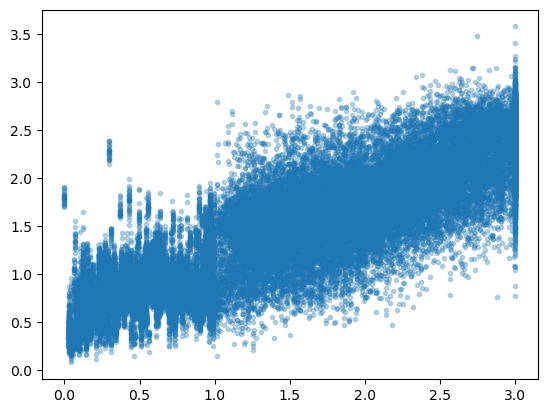

In [18]:
plt.plot(train_y,model(train_x_scaled).numpy(),'.', alpha=0.3)
plt.show()

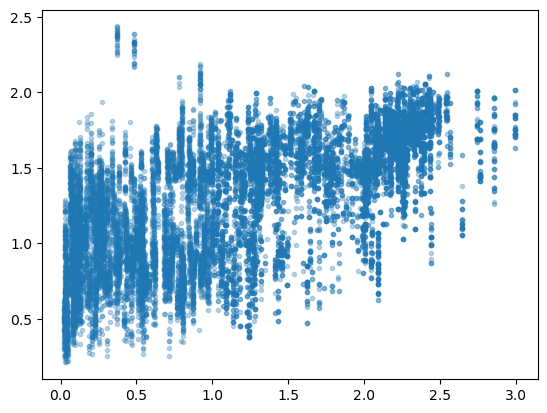

In [19]:
predictions = model(test_x_scaled).numpy()
valid_predictions = model(valid_x_scaled).numpy()
all_predictions = np.concatenate((predictions[:,0],valid_predictions[:,0]))
all_y = np.concatenate((test_y,valid_y))
plt.plot(all_y, all_predictions,'.', alpha=0.3)
plt.show()

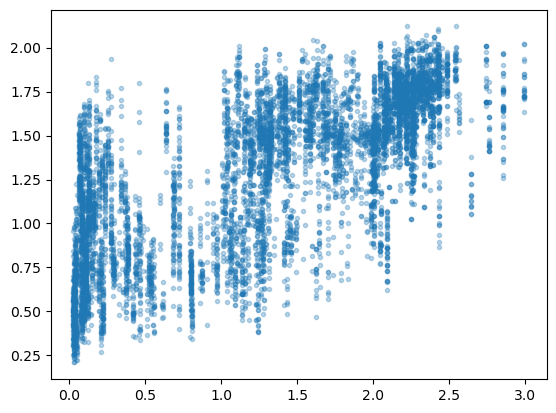

In [15]:
plt.plot(valid_y,model(valid_x_scaled).numpy(),'.', alpha=0.3)
plt.show()

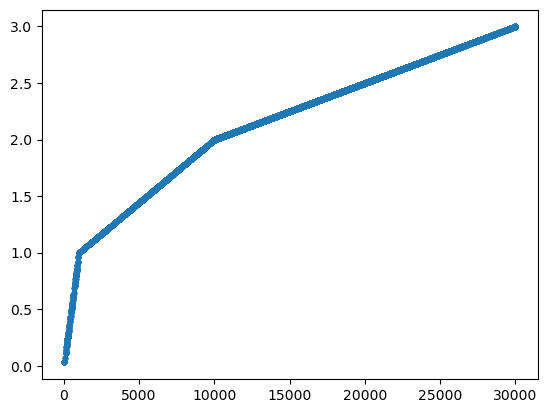

In [25]:
plt.plot(df_test['station_vis'].values,test_y,'.')
plt.show()

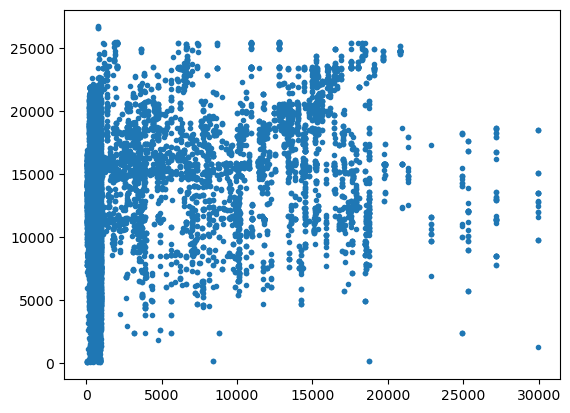

In [16]:
plt.plot(df_test['station_vis'].values,df_test['visi'],'.')
plt.show()

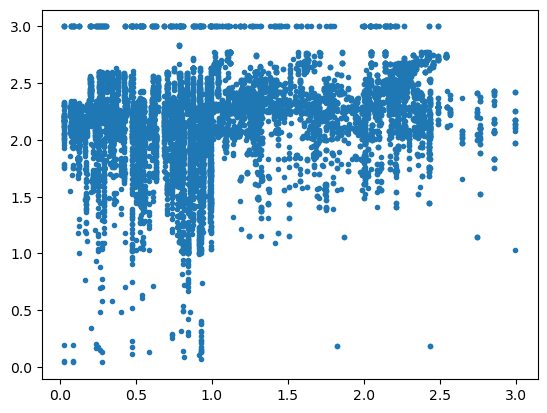

1.526702499673202
相关系数0.23269957328616203, p值为0.00000


In [17]:
plt.plot(df_test['station_vis'].apply(linear_vis),df_test['visi'].apply(linear_vis),'.')
plt.show()
print(mean_squared_error(df_test['station_vis'].apply(linear_vis),df_test['visi'].apply(linear_vis)))
r,p = pearsonr(df_test['station_vis'].apply(linear_vis),df_test['visi'].apply(linear_vis))
print(f'相关系数{r}, p值为{p:.5f}')

In [ ]:
p_test = tf.nn.softmax(predictions).numpy()

In [ ]:
p_test[:,0]

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [ ]:
df_p_test = pd.DataFrame({'p_fog':p_test[:,0],'p_mist':p_test[:,1],'p_clear':p_test[:,2]})

IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
df_p_test['p_clear'].plot()
df_p_test['p_mist'].plot()
df_p_test['p_fog'].plot()

In [ ]:

df_test_result = df_test.join(df_p_test) 
print(df_test_result.head())
df_test_result.to_csv('df_test_result.csv')

In [ ]:
# 各类别预测准确性对比
# 筛选出不同类别 df_all.loc[df_all['station_vis_cat'] == 2]
# 计算输出的类别 